In [1]:
%matplotlib notebook

In [2]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.utils.extmath import cartesian

Hello there, If you have found this through reddit or social media sharing sites, you should be aware that this iPython Notebook is a companion piece to a talk I gave at Sydney Python. The full write-up can be found [here](http://blog.chewxy.com/2016/09/30/how-to-make-money/) and the slides that precede and succeed this simulation can be found [here](https://speakerdeck.com/chewxy/how-to-make-money-how-money-is-created-in-the-economy). I recommend reading in this order: 

1. [Slides](https://speakerdeck.com/chewxy/how-to-make-money-how-money-is-created-in-the-economy) (until Let's Simulate)
2. This simulation
3. [Slides](https://speakerdeck.com/chewxy/how-to-make-money-how-money-is-created-in-the-economy) (for some takeaway bullet points)
4. [Blog post](http://blog.chewxy.com/2016/09/30/how-to-make-money/) for further discussions

Also, come caveats: I have purposely omitted discussions of stuff such as the effect of money supply and demand on wealth. It should be quite immediately obvious the moment you start thinking of money as a good as well. However, I have found through previous experience of teaching this to people, that it's not a good way to help them understand how money is created


Welcome to the great nation of Dystopianistan. The eternal leader is Kimberly Il-Smith. Here in Dystopianistan, things are done slightly differently from how you know them to be. But there are some quite familiar things. We'll start with one of them: the idea of `Bank`s

`Bank`s provide a place for the citizens of Dystopianistan to store their money. It also provides loans to any citizen who needs it. Loans in Dystopianistan are rather simple - there is no concept of compound interest. Also, all loans are set for a fixed period of time

`Bank`s loan money with special rules - they can loan more than they actually have. If a `Bank` holds \$200 in its holdings, it can loan up to \$1000. The reason is because through a lot of study, it's been found that the citizens of Dystopianistan are generally good debtors - they pay back whatever they owe, plus interest, most of the time. This allows the banks to count on future returns, and so they're allowed to lend out more money than they have in store.

In [3]:
interest_rate = 0.1
reserve_rate = 0.2

class Bank(object):
    def __init__(self, interest_rate, reserve_rate):
        self.interest_rate = interest_rate
        self.reserve_rate = reserve_rate
        self.loans = []
        self.unrecovered = 0.0
        self.holding = 0.0
    def can_lend(self, amount):
        # check if there is enough money in holdings
        if self.unrecovered+amount > 1/self.reserve_rate*self.holding:
            return False # cannot loan any more money
        return True
    def lend(self, loan):
        self.unrecovered += loan.amount
    def repay(self, loan):
        self.unrecovered -= loan.repay_amount()


class Loan(object):
    def __init__(self, lender, borrower, amount, repay_at, interest_rate):
        self.lender = lender
        self.borrower = borrower
        self.amount = amount
        self.repay_at = repay_at
        self.interest_rate = interest_rate
    def repay_amount(self):
        return self.amount * (1 + self.interest_rate)
    def __repr__(self):
        return "{} | {}".format(self.repay_amount(), self.repay_at)




central_bank = Bank(interest_rate, reserve_rate)


In Dystopianistan, citizens are also able to make investments. Investments are also simple here. At the end of 7 periods, citizens get a return on investment by means of upgrading their skills - they simply become more productive depending on how much investment they put in.

In [4]:
class Investment(object):
    def __init__(self, principle, return_rate, return_at):
        self.principle = principle
        self.return_rate = return_rate
        self.return_at = return_at
        self.p = abs(random.gauss(0, 0.01)) # half normal distribution
    def __repr__(self):
        return "{} | {}".format(self.principle, self.return_at)

The citizens of Dystopianistan are very different from what you normally know as people. They are born as full adults, with the capacity to produce things. Right from the moment they are born, they are thrust into the economic machine, producing and consuming goods. Due to their highly efficient nature, the citizens of Dystopianistan only consume goods once every period. Likewise, they produce goods only once every period.

Despite all that, the citizens of Dystopianistan are not robots. They are quite varied. Each citizen has different likes and dislikes (we call those `preferences`), and each citizen has different skills in producing goods (we call those `productivities`). Also, each citizen of Dystopianistan have different preferences for risk - some like to save more money now (`savings_pref`), some like to invest more money for future benefit (`investment_pref`). 

Consumption of goods make Dystopianistanians happy - a citizen may be good at producing oranges, but she may like apples more than oranges. Therefore she does the logical thing - sell her oranges and buy apples instead. However, sometimes, the prices of apples may be too high for her consumption habit, so she has to either cut down her consumption of apples, or take out a loan.

Consequently, every Dystopianistanian also has a likelihood of taking out a loan to fuel his/her spending habits (we call that `consumerism`).

In determining if a citizen is qualified for a loan, we'd have to calculate their `creditworthiness`. 

In [5]:
DEFAULT_THRESHOLD = 4
class Person(object):
    def __init__(self, bank, endowment, productivities, preferences, investment_pref, savings_pref):
        '''
        :param bank: which Bank does this Person banks with?
        :param endowment: how much savings does a person initially start with? rich families = high endowment
        :param productivities: a list of numbers the size of `basket`. 
                               This represents how many goods Person can produce per period.
        :param preferences: a list of floats the size of `basket`
        :param investment_pref: a float between [0,1). 0 = person doesn't care about his/her future earnings
        '''
        self.bank = bank
        self.savings = endowment
        self.bank.holding += self.savings
        self.productivities = productivities
        self.preferences = preferences
        self.investment_pref = investment_pref
        self.savings_pref = savings_pref
        self.loans = []
        self.investments = []
        self.last_income = endowment
        self.nonpayment = 0
        self.defaulted = False
        self.consumerism = np.random.beta(3,5)

    def utility(self, q, investment):
        '''
        utility represents a utility a Person has when presented with an allocation of goods and investment.
        
        :param q: a list of quantities
        :param investment: a number
        '''
        u = 1
        for g, p in zip(q, self.preferences):
            u *= math.pow(g, p)
        u *= math.pow(investment, self.investment_pref)
        return u

    def normalized_preferences(self):
        return [pref/(sum(self.preferences)+self.investment_pref+self.savings_pref) for pref in self.preferences]
    
    def normalized_productivities(self):
        return [prod/sum(self.productivities) for prod in self.productivities]
    
    def produce(self, priceMatrix, current):
        '''
        produce simulates the production capactity of a Person. 
        '''
        normal_prod = np.array(self.normalized_productivities())
        budget = self.budget(current)
        quantities = normal_prod * priceMatrix
        return quantities

    def consume(self, priceMatrix, current):
        '''
        Returns the demand given the prices. Demand is inelastick, because these Persons are turdballs.
        '''
        normal_pref = np.array(self.normalized_preferences())
        budget = self.budget(current)
        quantities = normal_pref * budget / priceMatrix
        return quantities
    
    def budget(self, current):
        '''
        The budget forms the constraint for a Person in his/her consumption
        '''
        repayments = 0.0
        for loan in self.loans:
            if current == loan.repay_at:
                repayments += loan.repay_amount()
        return self.creditworthiness()*self.consumerism + self.savings # - repayments

    def creditworthiness(self):
        '''
        creditworthiness determines how much a Person can borrow from the bank
        '''
        if self.savings > 0:
            return self.last_income + (self.last_income * interest_rate) + self.savings
        elif self.last_income > 0:
            return self.last_income + (self.last_income * interest_rate)
        return 0 # NO CREDIT FOR YOU!
    
    def debt(self):
        '''
        How much debt does a Person have?
        '''
        amount = 0.0
        for loan in self.loans:
            amount += loan.repay_amount()
        return amount
    
    def spend(self, amount, current):
        if amount < self.savings:
            self.savings -= amount
            return
        elif amount > self.savings:
            if self.bank.can_lend(amount):
                loan = Loan(self.bank, self, self.creditworthiness(), current+5, interest_rate)
                self.loans.append(loan)
                self.bank.lend(loan)
        else:
            self.savings = 0
            
    def earn(self, income):
        self.savings += income
        self.last_income = income

    def invest(self, amount, current):
        investment = Investment(amount, interest_rate, current+7)
        self.investments.append(investment)

    def step(self, prices, current):
        production = self.produce(prices, current)
        income = sum([p*q for p, q in zip(prices, production)])
        consumption = self.consume(prices, current)
        
        inv_pref = self.investment_pref/(sum(self.preferences)+self.investment_pref)
        inv_amt = inv_pref * self.budget(current)
        
        norm_prod = self.normalized_productivities()
        prod_cost = [p*q for p, q in zip(prices, production)]
        prod_cost = sum(n*c for n, c in zip(norm_prod, prod_cost))
        
        cost = sum([p*q for p, q in zip(prices, consumption)]) + inv_amt + prod_cost
        self.earn(income)
        self.spend(cost, current)
        if self.savings > inv_amt:
            self.invest(inv_amt, current)
        
        # remove loans that are up
        remove = []
        cantpay = False
        for loan in self.loans:
            if loan.repay_at <= current:
                if self.savings >= loan.repay_amount():
                    self.savings -= loan.repay_amount()
                    self.bank.repay(loan)
                    remove.append(loan)
                else:
                    cantpay = True
        for loan in remove:
            self.loans.remove(loan)
            
        if cantpay:
            self.nonpayment += 1
        
        # realize investments
        remove = []
        for investment in self.investments:
            if investment.return_at == current:
                self.savings += investment.principle*(1+investment.return_rate)
                self.productivities = [prod *(1+investment.p) for prod in self.productivities]
                remove.append(investment)
        for investment in remove:
            self.investments.remove(investment)
            
        # check for defaults
        if self.nonpayment >= DEFAULT_THRESHOLD:
            self.defaulted = True
            default_amt = 0.0
            for loan in self.loans:
                default_amt += loan.amount
            self.bank.unrecovered -= default_amt
            


In [6]:
basket = 3
endowment = random.gauss(50,10)
preferences = np.random.randint(0,10, basket)
skills = np.random.randint(0,10, basket)
investment_pref = np.random.randint(0,10)
savings_pref = np.random.randint(0,10)
A = Person(central_bank,endowment, skills, preferences, investment_pref, savings_pref)

for i in range(2):
    prices = np.random.beta(3,2, (3,basket)) * 10
    production = A.produce(prices,i)
    income = sum([p*q for p, q in zip(prices, production)])
    consumption = A.consume(prices,i)
    consumes = sum([p*q for p,q in zip(prices, consumption)])
    A.step(prices[0], i)

    print("Step {}".format(i))
    print("Price: \n{}".format(prices))
    print("Budget {}".format(A.budget(i)))
    print("Productivity \n{}".format(production))
    print("Consumption \n{}".format(consumption))
    print("Income: {} {}".format(A.last_income, income))
    print("Savings: {}".format(A.savings))
    print("Cost: {}".format(consumes))
    print("Debt: {}".format(A.debt()))
    print("Creditworthiness {}".format(A.creditworthiness()))
    print("Loans: {}".format(A.loans))
    print("Investments: {}".format(A.investments))
    print("\n\n")


Step 0
Price: 
[[ 6.25779811  4.8407418   8.53576085]
 [ 4.86361893  0.85140465  4.89598127]
 [ 7.76590991  6.22534919  5.23620681]]
Budget 100.19693909148224
Productivity 
[[ 0.62577981  4.35666762  0.        ]
 [ 0.48636189  0.76626419  0.        ]
 [ 0.77659099  5.60281427  0.        ]]
Consumption 
[[ 4.63420764  0.          4.75644888]
 [ 5.96262499  0.          8.29249703]
 [ 3.73426116  0.          7.75368728]]
Income: 25.00550675496667 [ 12.31241831  56.62137924   0.        ]
Savings: 73.45868292978126
Cost: [  86.99980738    0.          121.79973034]
Debt: 111.06121439626908
Creditworthiness 100.9647403602446
Loans: [111.06121439626908 | 5]
Investments: [5.799987158821237 | 7]



Step 1
Price: 
[[ 6.85203611  7.55341235  1.91544356]
 [ 6.54631308  7.94648689  4.2333081 ]
 [ 5.23807973  7.5254535   4.11447725]]
Budget 180.12427044122256
Productivity 
[[ 0.68520361  6.79807112  0.        ]
 [ 0.65463131  7.1518382   0.        ]
 [ 0.52380797  6.77290815  0.        ]]
Consumption

Consider a small subset of the population of Dystopianistan where there are two citizens, Alice and Bob, and they only produce two goods: apples and oranges.

This is what they produced:
<table>
<thead><th>Who</th><th>Apples Produced</th><th>Oranges Produced</th></thead>
<tbody>
<tr><td>Alice</td><td>5</td><td>10</td></tr>
<tr><td>Bob</td><td>12</td><td>5</td></tr>
</table>

This is what each of them prefer to have:

<table>
<thead><th>Who</th><th>Apples Prefered</th><th>Oranges Prefered</th></thead>
<tbody>
<tr><td>Alice</td><td>8</td><td>2</td></tr>
<tr><td>Bob</td><td>9</td><td>13</td></tr>
</table>

This can be solved quite easily with basic algebra:

$$3A - 8O = 0$$
$$A = \frac{8}{3}O$$

While it was simple to solve for Alice and Bob, the process of solving it for everyone take $\mathcal{O}(n^n)$. Instead, the geniuses at Dystopianistan came up with a novel idea: 

1. Poll everyone to see what they would produce given that a good is at a certain price.
2. Poll everyone to see what they would consume given that a good is at a certain price.
3. Calculate a fair price for every good in the world
4. Everyone by law must sell all the goods they produce per period and buy whatever they want at that price.
5. They would build a supercomputer to calculate all the prices - it'd be called InvisibleHandatron 2000.

Through meticulous study, they have discovered that this method is indeed the most fair method of redistributing the goods - at least in theory. The end result was [Pareto optimal](https://en.wikipedia.org/wiki/Pareto_efficiency) - where no one can be made better off without making someone worse off.

So, back to the example with Alice and Bob. Let's say the fair price for Apples are \$3, and the fair price for oranges are \$8.

First, they both sell all their goods to InvisbleHandatron 2000:

<table>
<thead><th>Who</th><th>Income From Apples</th><th>Income from Oranges</th><th>Total Income</th></thead>
<tbody>
<tr><td>Alice</td><td>\$15</td><td>\$80</td><td>\$95</td></tr>
<tr><td>Bob</td><td>\$36</td><td>\$40</td><td>$76</td></tr>
</table>

They then buy back however much they prefer from InvisibleHandatron 2000:

<table>
<thead><th>Who</th><th>Cost of buying Apples</th><th>Cost of buying Oranges</th><th>Total Cost</th></thead>
<tbody>
<tr><td>Alice</td><td>\$24</td><td>\$20</td><td>\$45</td></tr>
<tr><td>Bob</td><td>\$27</td><td>\$104</td><td>\$131</td></tr>
</table>

Here you might notice Bob doesn't make quite enough money to buy what he prefers. But who knows? He may crack into his savings. Or he might take a loan to fund his fruit-related addiction. Or he may choose to eat fewer fruits and go to the toilet less. Either way, the story has ended.


In [7]:
class Market(object):
    current = 0
    def __init__(self, thickness, basket, bank, max_price, steps):
        self.basket = basket
        self.participants = []
        self.bank = bank
        self.max_price = max_price # government intervention! This is the price ceiling that the government sets
        self.steps = steps         # how many steps to break down from 0 to max price
        for i in range(thickness):
            endowment = random.gauss(50,10)
            preferences = np.random.randint(1,10, self.basket)
            skills = np.random.randint(1,10, self.basket)
            investment_pref = np.random.randint(0, 10)
            savings_pref = np.random.randint(0,10)
            participant = Person(bank,endowment, skills, preferences, investment_pref, savings_pref)
            self.participants.append(participant)
    def demand(self, priceMatrix):
        quantities = np.zeros((priceMatrix.shape[0], priceMatrix.shape[1]))
        for participant in self.participants:
            quantities += participant.consume(priceMatrix, self.current)
        return quantities
    
    def supply(self, priceMatrix):
        quantities = np.zeros((priceMatrix.shape[0], priceMatrix.shape[1]))
        for participant in self.participants:
            q = participant.produce(priceMatrix, self.current)
            quantities += q
        return quantities 

    
    def market_price(self):
        prices = (np.arange(self.steps) + 1) * self.max_price / float(self.steps)
        priceMatrix = np.tile(prices.reshape(self.steps,1), (1, self.basket))
#         priceMatrix = cartesian([prices for i in range(m.basket)])
        
        supply = self.supply(priceMatrix)
        demand = self.demand(priceMatrix)
        surplus = supply - demand
        min_surplus = np.argmin(np.abs(surplus),0)
        eq_prices = []
        for i in range(self.basket):
            eq_prices.append(priceMatrix[min_surplus[i]][i])
        return np.array(eq_prices)

    def step(self):
        eq_prices = self.market_price()
        for participant in self.participants:
            if not participant.defaulted:
                central_bank.holding -= participant.savings
                participant.step(eq_prices, m.current)
                central_bank.holding += participant.savings
                
        m.current += 1
    
    def m1(self):
        money = 0.0
        for participant in self.participants:
            if not participant.defaulted and participant.savings > 0:
                money += participant.savings
        return money
    def m2(self):
        money = 0.0
        for participant in self.participants:
            if not participant.defaulted:
                for loan in participant.loans:
                    money += loan.amount * (1+loan.interest_rate)
        return money

    def actives(self):
        return sum([1 for p in self.participants if not p.defaulted])

The market is quite self explanatory - at every time period, it calculates the equilibrium price. Remember, the citizens of Dystopianistan are [price takers](http://www.investopedia.com/terms/p/pricetaker.asp) with InvisbleHandatron being the price maker. 

Here we see how the price is calculated:

Market Price: [ 8.  8.  8.  8.]


<IPython.core.display.Javascript object>


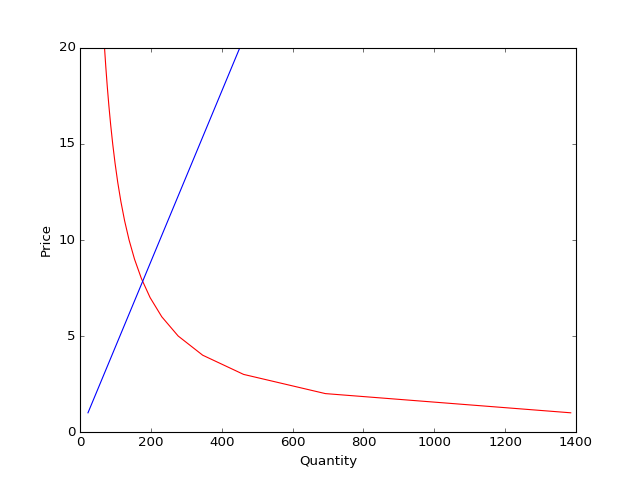

In [8]:
basket = 4
m = Market(100, basket, central_bank, 20, 20)
prices = (np.arange(m.steps) + 1) * m.max_price / float(m.steps)
# priceMatrix = cartesian([prices for i in range(m.basket)])
priceMatrix = np.tile(prices.reshape(m.steps,1), ( 1, basket))
supply = m.supply(priceMatrix)
demand = m.demand(priceMatrix)
market_price = m.market_price()
print("Market Price: {}".format(market_price))

fig, ax = plt.subplots(1,1)
ax.set_xlabel("Quantity")
ax.set_ylabel("Price")
ax.plot(demand.T[0],priceMatrix.T[0], c='r')
ax.plot(supply.T[0],priceMatrix.T[0], c='b')
fig.canvas.draw()


It should come to no surprise that the chart looks very close to the traditional supply-demand charts you see in economics text books. Afterall, the citizens of Dystopianistan are generally quite rational.


In [9]:
def plotmoney(ax, steps, m1s, m2s):
    ax.lines[0].set_xdata(steps)
    ax.lines[1].set_xdata(steps)
    ax.lines[0].set_ydata(m1s)
    ax.lines[1].set_ydata(m2s)
    
def plotpeople(ax, steps, people):
    ax.lines[0].set_xdata(steps)
    ax.lines[0].set_ydata(people)

def plotprices(ax, steps, goods):
    for i, g in enumerate(goods):
        ax.lines[i].set_xdata(steps)
        ax.lines[i].set_ydata(g)

And now, the simulation of how things work in Dystopianistan. Recall earlier that Dystopianistan has discovrered that the citizens are generally good payers-back of loans? Well, here's a how's-the-sausage-is-made reasoning for that: they simply throuw debtors who have failed to pay back their loans `DEFAULT_THRESHOLD` times, into the gulag, removing them from the economy entirely.

It would make sense too. If you analyze their behaviour, the defaulters generally have high `consumerism` preferences. They typicallly spend more than they can make. Therefore in her Great Knowledge, the Eternal Glorious Leader of Dystopianistan has decided to cast those who default into little boats along the river (the Eternal Glorious Leader has plans with those boats obviously - to send them to explore *Terra Australis Incognita* in about 10 years time)

50145.13008641936
1000


<IPython.core.display.Javascript object>


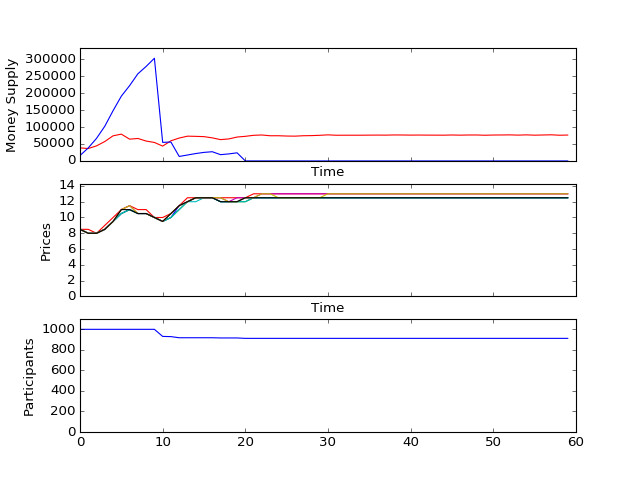

In [17]:
#reset in case the below case "no loans allowed" is run previously
def budget(self, current):
    '''
    The budget forms the constraint for a Person in his/her consumption
    '''
    repayments = 0.0
    for loan in self.loans:
        if current == loan.repay_at:
            repayments += loan.repay_amount()
    return self.creditworthiness()*self.consumerism + self.savings # - repayments
Person.budget = budget
central_bank = Bank(interest_rate, reserve_rate)

n_steps = 60
participant_count = 1000
max_price = 100
price_steps = 200
basket = 7
m = Market(participant_count, basket, central_bank, max_price, price_steps)
print(central_bank.holding)
print(len(m.participants))
mp = m.market_price()

fig,(ax1,ax2, ax3) = plt.subplots(3,1, sharex=True)
ax1.set_xlabel('Time')
ax1.set_ylabel('Money Supply')
ax1.set_xlim(0,n_steps)
ax1.set_ylim(0,700000)
ax2.set_xlabel('Time')
ax2.set_ylabel('Prices')
ax2.set_xlim(0,n_steps)
ax2.set_ylim(0,35)
ax3.set_ylabel("Participants")
ax3.set_ylim(0,participant_count*1.1)


steps =[0]
m1s = [m.m1()]
m2s = [m.m2()]
participants = [participant_count]
prices = [[p] for p in mp]
colors = ['r', 'b', 'g', 'c', 'm', 'y','k']

ax1.plot(steps, m1s, c='r')
ax1.plot(steps, m2s, c='b')
ax3.plot(steps, participants)
for i, p in enumerate(prices):
    ax2.plot(steps, p, c=colors[i])
fig.canvas.draw()

for i in range(n_steps):
    mp = m.market_price()
    m.step()

    steps.append(i)
    m1 = m.m1()
    m2 = m.m2()
    
    # plotting shit
    m1s.append(m1)
    m2s.append(m2)
    for i, p in enumerate(mp):
        prices[i].append(p)

    participants.append(m.actives())
    
    maxY1 = max(m1s+m2s)*1.1
    maxY2 = max([p for pl in prices for p in pl ])*1.1
    ax1.set_ylim(0, maxY1)
    ax2.set_ylim(0, maxY2)
    plotmoney(ax1, steps, m1s, m2s)
    plotprices(ax2, steps, prices)
    plotpeople(ax3, steps, participants)
    
    fig.canvas.draw()
#     print("Time {}. M1: {}, M2: {}, Total: {}".format(i, m1, m2, m1+m2))
    

What happens if loans cannot be made? 

In [15]:
import types
central_bank2 = Bank(interest_rate, reserve_rate)
central_bank2.can_lend = types.MethodType(lambda bank, amount: False, central_bank2) # never do this on prod servers!
Person.budget = lambda self, cuurent: self.savings

As you'll note - nothing interesting happens if there are no loans allowed. The economy stagnates. A stagnating economy usually spells civil unrest

49637.82289894139
1000


<IPython.core.display.Javascript object>


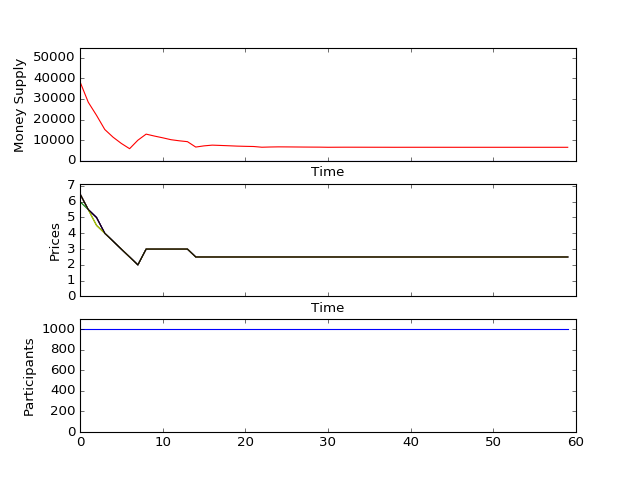

In [16]:
m = Market(participant_count, basket, central_bank2, max_price, price_steps)
print(central_bank2.holding)
print(len(m.participants))
mp = m.market_price()

fig,(ax1,ax2, ax3) = plt.subplots(3,1, sharex=True)
ax1.set_xlabel('Time')
ax1.set_ylabel('Money Supply')
ax1.set_xlim(0,n_steps)
ax1.set_ylim(0,700000)
ax2.set_xlabel('Time')
ax2.set_ylabel('Prices')
ax2.set_xlim(0,n_steps)
ax2.set_ylim(0,35)
ax3.set_ylabel("Participants")
ax3.set_ylim(0,participant_count*1.1)


steps =[0]
m1s = [m.m1()]
m2s = [m.m2()]
participants = [participant_count]
prices = [[p] for p in mp]
colors = ['r', 'b', 'g', 'c', 'm', 'y','k']

ax1.plot(steps, m1s, c='r')
ax1.plot(steps, m2s, c='b')
ax3.plot(steps, participants)
for i, p in enumerate(prices):
    ax2.plot(steps, p, c=colors[i])
fig.canvas.draw()

for i in range(n_steps):
    mp = m.market_price()
    m.step()

    steps.append(i)
    m1 = m.m1()
    m2 = m.m2()
    
    # plotting shit
    m1s.append(m1)
    m2s.append(m2)
    for i, p in enumerate(mp):
        prices[i].append(p)

    participants.append(m.actives())
    
    maxY1 = max(m1s+m2s)*1.1
    maxY2 = max([p for pl in prices for p in pl ])*1.1
    ax1.set_ylim(0, maxY1)
    ax2.set_ylim(0, maxY2)
    plotmoney(ax1, steps, m1s, m2s)
    plotprices(ax2, steps, prices)
    plotpeople(ax3, steps, participants)
    
    fig.canvas.draw()
#     print("Time {}. M1: {}, M2: {}, Total: {}".format(i, m1, m2, m1+m2))